In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [78]:
def sperate_point(point1, point2, center_coordinates, axes_lengths, angle):

    # 计算向量1和向量2
    vector1 = (point1[0] - center_coordinates[0], point1[1] - center_coordinates[1]) 
    vector2 = (point2[0] - center_coordinates[0], point2[1] - center_coordinates[1]) 

    # 计算与水平轴的夹角（弧度）
    theta1 = np.arctan2(vector1[1], vector1[0])
    theta2 = np.arctan2(vector2[1], vector2[0])
    
    if theta1 > theta2: theta2 += math.pi * 2
    # print(theta1, theta2)
    # # 生成中间点
    num_points = 10  # 等分点数
    t_values = np.linspace(theta1, theta2, num_points + 1)  # 等间距划分
    
    # # 计算椭圆上的点（在椭圆旋转前）
    points = []
    for t in t_values:
        x = axes_lengths[0] * np.cos(t)
        y = axes_lengths[1] * np.sin(t)
    
        # # 应用旋转变换
        rotation_matrix = np.array([
            [np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
            [np.sin(np.radians(angle)), np.cos(np.radians(angle))]
        ])

        rotated_point = rotation_matrix @ np.array([x, y])
        points.append((int(rotated_point[0] + center_coordinates[0]), int(rotated_point[1] + center_coordinates[1])))

    # # 绘制分点，并显示红色端点
    # for i, point in enumerate(points):
    #     if i % 2 : continue
    #     color = (0, 0, 255) if i == 0 or i == len(points) - 1 else (0, 255, 0)  # 红色端点，绿色中间点
    #     cv2.circle(gray_img2, point, radius=1, color=color, thickness=-1)
    return points

In [79]:
def load_template():
    
    img1 = cv2.imread('source/template.jpg') 
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    
    # 椭圆参数
    center_coordinates = (int(884), int(554))  # 椭圆中心 (x, y)
    axes_lengths = (int(448.944 / 2), int(446.030 / 2))  # OpenCV使用半轴
    angle = 0
    start_angle = 0  # 起始角度
    end_angle = 360  # 终止角度
    color = (255, 255, 255)  # 白色椭圆 (RGB)
    thickness = 2  # 椭圆线的厚度
    
    gray_img2 = cv2.ellipse(img1, center_coordinates, axes_lengths, angle, start_angle, end_angle, color, thickness)
    
    standard_point = [
        (737,762),
        (718,745), (701,729), (685,711), (671,692), (658,671),
        (648,650), (640,626), (634,604), (630,579), (629,555),
        (630,530), (633,506), (639,482), (647,459), (657,437),
        (670,416), (684,397), (700,379), (718,362), (737,347),
        (759,334), (777,325), (795,317), (815,311), (834,306),
        (855,303), (877,303), (900,303), (924,306), (948,310),
        (972,318), (993,327), (1013,337), (1033,350),(1050,364),
        (1067,379), (1082,397), (1094,414), (1108,436),(1118,457),
        (1126,480), (1132,503), (1136,526), (1137,550),(1136,573),
        (1133,597), (1128,620), (1120,642), (1111,664), (1099,685),
        (1085,704), (1071,723)
    ]
    
    candidate_point = []
    for i in range(len(standard_point) - 1):
        # print(standard_point[i], standard_point[i+1])
        res_point = sperate_point(standard_point[i], standard_point[i + 1], center_coordinates, axes_lengths, angle)
        if len(candidate_point) and res_point[0] == candidate_point[-1]: 
            candidate_point += res_point[1:]
        else: candidate_point += res_point

    print(f'get Candidate Points {len(candidate_point)}')
    return candidate_point

In [80]:
def findH(gray_img1, gray_img2):
    # Initialize the SIFT detector
    # sift = cv2.SIFT_create()

    # # Detect keypoints and compute descriptors in both images
    # keypoints1, descriptors1 = sift.detectAndCompute(gray_img1, None)
    # keypoints2, descriptors2 = sift.detectAndCompute(gray_img2, None)
    
    # # Match descriptors using KNN (k=2)
    # bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    # matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # # Apply ratio test to filter good matches
    # good_matches = []
    # for m, n in matches:
    #     if m.distance < 0.4 * n.distance:
    #         good_matches.append(m)

    akaze = cv2.AKAZE_create()
    # 检测关键点和计算描述符
    keypoints1, descriptors1 = akaze.detectAndCompute(gray_img1, None)
    keypoints2, descriptors2 = akaze.detectAndCompute(gray_img2, None)
    # 使用 BFMatcher 匹配描述符
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    # 按照距离将匹配结果排序
    matches = sorted(matches, key=lambda x: x.distance)
    
    # 只保留前50个匹配（你可以调整这个数值）
    good_matches = matches[:50]

    # Extract the matched keypoints4
    if len(good_matches) > 4:  # At least 4 points needed to compute homography
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Compute the homography matrix using RANSAC
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        print('H founded')
        return H
    else:
        print("Not enough matches found to compute homography.")
        return None

In [81]:
def cross(x1,y1,x2,y2):
    return x1 * y2 - x2 * y1
def sgn(x):
    if math.fabs(x) < 1e-6: return 0
    return 1 if x > 0 else -1

In [82]:
def test(img_path, candidate_point, number):
    
    print(f'checking: {img_path}')
    img1 = cv2.imread('source/template.jpg')  # 替换为你的第一张图片路径
    img2 = cv2.imread(img_path)  # 替换为你的第二张图片路径
    
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    H = findH(gray_img1, gray_img2)
    if H is None: return
    
    candidate_point = np.array(candidate_point, dtype=np.float32).reshape(-1, 1, 2)
    candidate_projected_points = cv2.perspectiveTransform(candidate_point, H)

    alpha = [0 for i in range(501)]
    for i in range(10, 510 + 1): 
        sum_k, cnt_empty = 0, 0
        for j in range(1,10 + 1):
            if i + j >= 520: continue
            delta_y = candidate_projected_points[i+j][0][1] - candidate_projected_points[i-j][0][1]
            delta_x = candidate_projected_points[i+j][0][0] - candidate_projected_points[i-j][0][0]

            if math.fabs(delta_x) < 1e-6: cnt_empty += 1
            else:
                sum_k += delta_y / delta_x

        if cnt_empty > 5 : alpha[i - 10] = 0.0
        else: 
            k_i =  sum_k / ( 10 - cnt_empty )
            if math.fabs(k_i) < 1e-6 : 
                alpha[i - 10] = 90.0
            else: 
                alpha[i - 10] = math.atan(-1 / k_i) * 180 / math.pi
    # Function to draw a line at point (x, y) with angle alpha relative to the horizontal
    
    
    img_copy = gray_img2.copy()
    w = 50
    theta = 5
    res_i, min_pixel = 0, 1e9

    for i in range(0,len(alpha)):

        x = candidate_projected_points[i+10][0][0]
        y = candidate_projected_points[i+10][0][1]

        alpha_rad = math.radians(alpha[i])
        theta_rad = math.radians(theta)

        vec1_x = math.cos(alpha_rad + theta_rad)
        vec1_y = math.sin(alpha_rad + theta_rad)

        # Coordinates of vec2 (rotated counterclockwise)
        vec2_x = math.cos(alpha_rad - theta_rad)
        vec2_y = math.sin(alpha_rad - theta_rad)

        x_min, x_max, y_min, y_max = int(x - w/2), int(x + w/2), int(y - w/2), int(y + w/2)
        
        y_min = max(0, y_min)
        y_max = min(1080, y_max)
        
        x_min = max(0, x_min)
        x_max = min(1920, x_max)
        
                
        sum_pixel = 0
        cnt = 0
        for ty in range(y_min, y_max):
            for tx in range(x_min, x_max):
                vx, vy = tx - x, ty - y
                if vx ** 2 + vy **2 > (w/2) ** 2: continue

                if sgn( cross(vec1_x, vec1_y, vx, vy) ) * sgn( cross(vec2_x, vec2_y, vx, vy) ) <= 0:
                    # img_copy[ty,tx] = 0
                    sum_pixel += img_copy[ty,tx]
                    cnt += 1

        if cnt > 0 and sum_pixel/cnt < min_pixel: 
            min_pixel = sum_pixel/cnt
            res_i = i    
            

    x = candidate_projected_points[res_i+10][0][0]
    y = candidate_projected_points[res_i+10][0][1]

    alpha_rad = math.radians(alpha[res_i])
    theta_rad = math.radians(theta)

    vec1_x = math.cos(alpha_rad + theta_rad)
    vec1_y = math.sin(alpha_rad + theta_rad)
    # Coordinates of vec2 (rotated counterclockwise)
    vec2_x = math.cos(alpha_rad - theta_rad)
    vec2_y = math.sin(alpha_rad - theta_rad)

    x_min, x_max, y_min, y_max = int(x - w/2), int(x + w/2), int(y - w/2), int(y + w/2)
    for ty in range(y_min, y_max):
        for tx in range(x_min, x_max):
            vx, vy = tx - x, ty - y
            if vx ** 2 + vy **2 > (w/2) ** 2: continue

            if sgn( cross(vec1_x, vec1_y, vx, vy) ) * sgn( cross(vec2_x, vec2_y, vx, vy) ) <= 0:
                img_copy[ty,tx] = 255

    P =( res_i / 500) * 1.0 - 0.1
    print(f'读数 = {P:.2f}MPa')

    plt.imshow(img_copy, cmap='gray')


    plt.axis('off')  # Remove axis for better visualization
    plt.savefig(f'res/{number}-{P:.2f}MPa.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

In [83]:
candidate_point = load_template()

get Candidate Points 521


checking: test/a (1).jpg
H founded
读数 = 0.55MPa


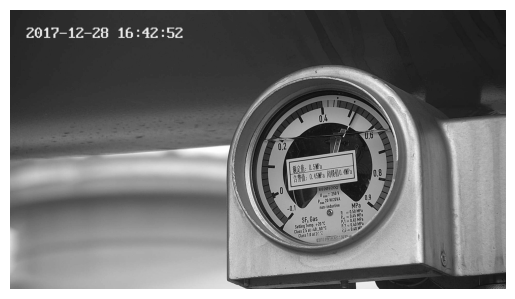

checking: test/a (2).jpg
H founded
读数 = 0.52MPa


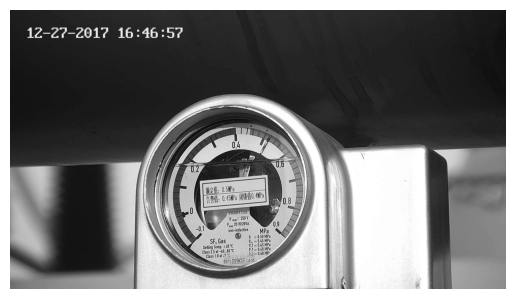

checking: test/a (3).jpg
H founded
读数 = 0.55MPa


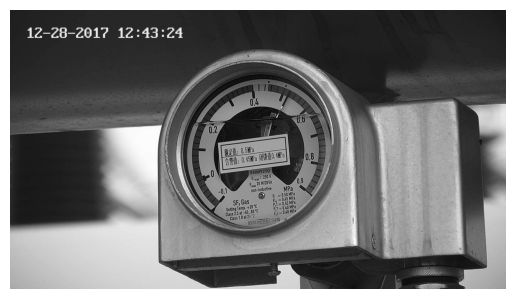

checking: test/a (4).jpg
H founded
读数 = 0.44MPa


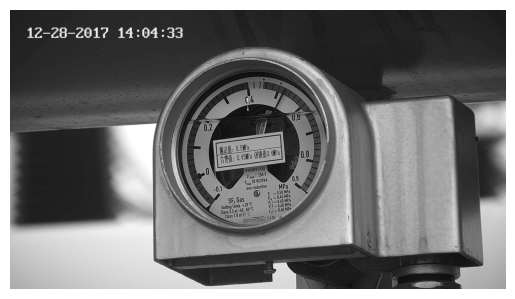

checking: test/a (5).jpg
H founded
读数 = 0.52MPa


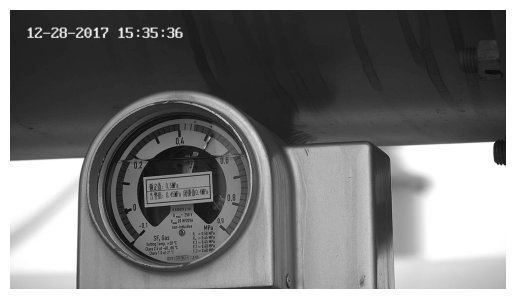

checking: test/a (6).jpg
H founded
读数 = 0.51MPa


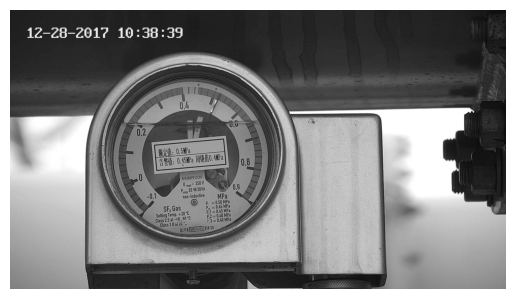

checking: test/a (7).jpg
H founded
读数 = 0.51MPa


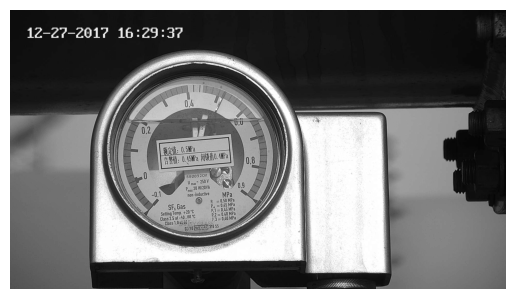

checking: test/a (8).jpg
H founded
读数 = 0.43MPa


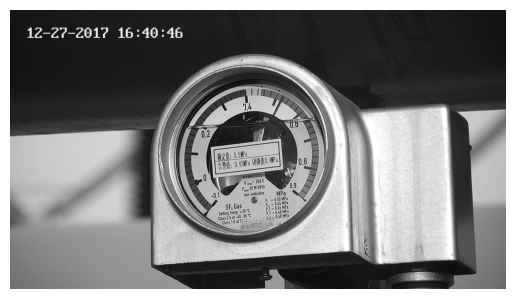

checking: test/a (9).jpg
H founded
读数 = 0.43MPa


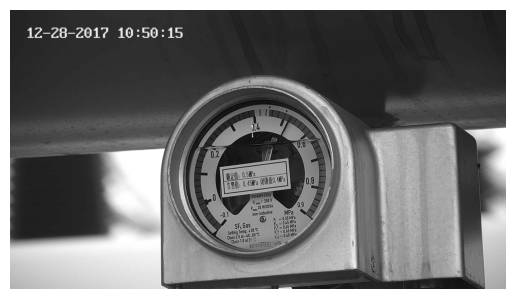

In [84]:
for number in range(1, 23):
    path = f'test/a ({number}).jpg'
    test(path, candidate_point, number)